<a href="https://colab.research.google.com/github/juanserrano90/codelatam/blob/main/DataPreparation/add_spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a draft for the add_spikes module to be added to generate the modified copies.

Author: Paula GM, built over code by Willow Fox Fortino
Date: Oct. 21th, 2024
Last Modified: Dec. 19th, 2024.

In [ ]:
import sys
from os.path import isfile
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import random
import logging

In [ ]:
logging.basicConfig(filename='modifications.txt', level=logging.info,
                    format='%(asctime)s - %(message)s', filemode='w')

In [ ]:
# -- Authors: Paula Gálvez Molina
# -- Modified from original code by : Willow Fox Fortino
# Last Modified: Oct. 21th, 2024

def add_spikes(spectrum, redshift, start=2501.69, end=9993.24):
    """Loosely simulate telluric lines by adding in one-pixel wide spikes to the
       spectra are expected de-redshifted telluric lines.

        Args:
        spectrum (float): Supernova spectrum to be modified.
        redshift (float): Redshift of the supernova of the corresponding spectrum.
        start (float): Minimum wavelength of the telluric line.
        end (float): Maximum wavelength of the telluric line.

        Returns:
        spiked (array): Spectrum array with spike(s) added."""

    # First decide how many spikes should be added. At most 5 and at minimum zero.
    num_spikes = stats.randint.rvs(low=0, high=4, size=1).item()

    # Construct the array of spikes that is the same shape as the original spectrum.
    spiked = spectrum.copy() #FBB move this to before tell_loc

    # FBB put this in a if statements
    if num_spikes>0:
      # Next decide the location of the spikes by approximating the first spike at around 760 nm (O2 A-Band) with corresponding redshift.
      # If more than one spike, then the location is given by choosing a random number between 0 and the length of the array containing the spectrum. These other lines intend to simulate artifact.
      tell_loc = 7600 / (redshift + 1)

      # Find the edges of the mask and redefine start and end as those values
      filter = spiked != 0
      nonzero_indices = np.nonzero(filter)[0]
      startSpec, endSpec = nonzero_indices[0], nonzero_indices[-1]

      # The spectrums are in logarithmic scale, so the index of the location of the spike must be determined by the location of the in the logarithmic array closest in value to the tell_loc.
      log_array = np.logspace(np.log10(start), np.log10(end), num=len(spectrum))    # Create the logarithmically spaced array
      # FBB you should not need to recreate this: it should be an object defined in the speclc where you et the spectra from

      idx = (np.abs(log_array - tell_loc)).argmin()     # Find the index of the element closest to the given value
      spike_loc = stats.randint.rvs(low=startSpec, high=endSpec, size=num_spikes) # FBB removed random state: that is set outside of this function
      if np.random.rand() > 0.75: # 1/4 of the times
        spike_loc[0] = idx + np.random.randint(-2,2) # Not necessarily on the pixel of the telluric line but +- 2 pixels

      # Next, we decide if the spike will be an addition or subtraction (i.e., if the telluric line is emission or absorption). 80% of the time, the spike will be in emission (a positive spike) and the rest of the time it will be in absorption.
      spike_dir = stats.binom.rvs(n=1, p=0.80, size=num_spikes)
      spike_dir[spike_dir == 0] = -1

      # Finally choose the magnitude of the spike. We take the absolute value since we are having the sign of the spike determined by the previous set of code.
      # The magnitude is drawn from a gaussian distribution with mean 1 and standard deviation 0.75 so that 68% values lie (0.75, 1.25) as determined by this study.
      spike_mag = np.abs(stats.norm.rvs(loc=1, scale=0.75, size=num_spikes))

      spiked[spike_loc] = spike_mag * spike_dir

      # Logging information
      logging.info(f'------Number of spikes to add: {num_spikes}')
      logging.info(f'------Location of spikes: {spike_loc}')
      logging.info(f'------Magnitude of spikes: {spike_mag}')
      logging.info(f'------Direction of spikes: {spike_dir}')

    return spiked, spike_loc

In [ ]:
url = "https://github.com/juanserrano90/codelatam/raw/main/Data/data/sn_data.parquet"
df_raw = pd.read_parquet(url)

In [ ]:
wavelength = np.array([float(c) for c in df_raw.columns[5:]])

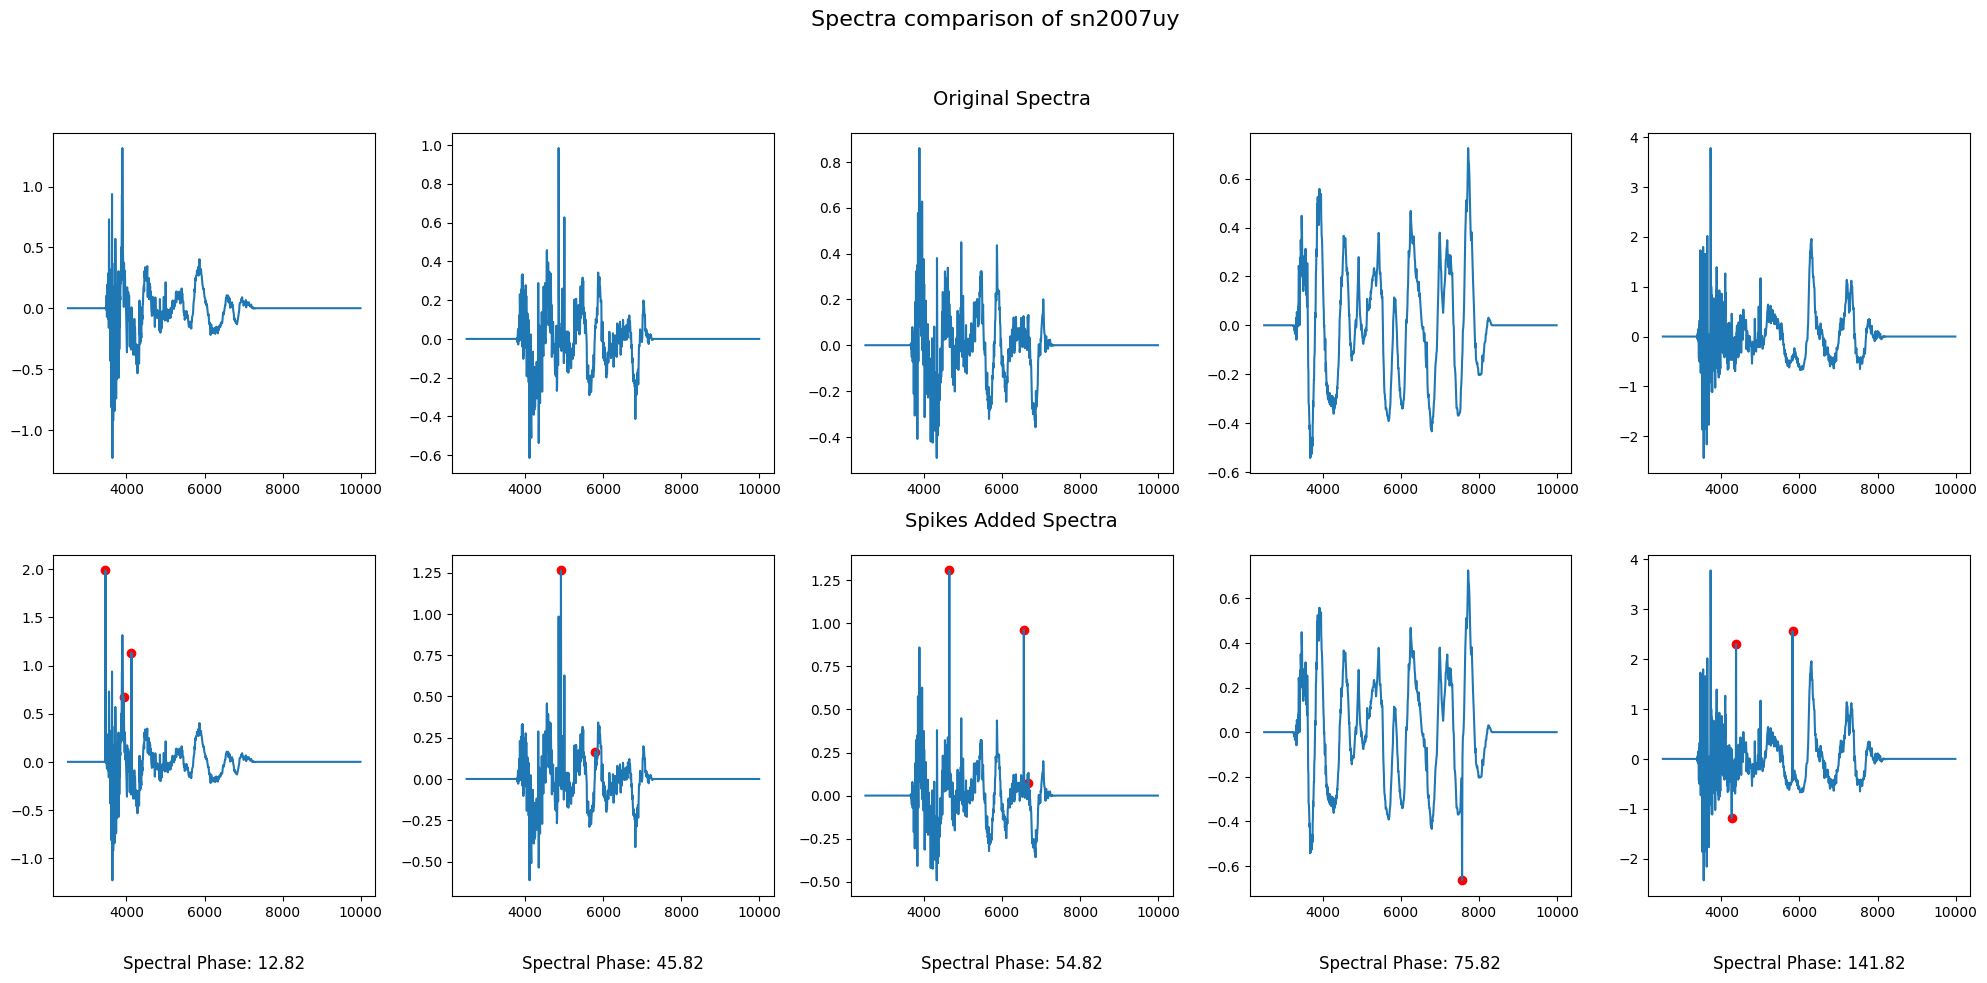

In [ ]:
np.random.seed(3312)
column_names = df_raw.columns.values.tolist()
column_names = np.array(column_names[5:]).astype(float)
sn_name = "sn2007uy"
spectral_phases = [12.82, 45.82, 54.82, 75.82, 141.82]
sample = []
for delay in spectral_phases:
  sample.append(df_raw.loc[(df_raw.index == sn_name) * (df_raw["Spectral Phase"] == delay)].iloc[:, 5:].values[0])
spiked = []
indices = []
for i,s in enumerate(sample):
  logging.info(f'Object: {sn_name}, phase delay: {spectral_phases[i]}')
  modified_spectrum, index = add_spikes(s, 0.005)
  spiked.append(modified_spectrum)
  indices.append(index)
  logging.info(f'\n')

fig, ax = plt.subplots(2, 5, figsize=(20, 10))

# Row 0: Raw spectra
for i in range(5):
    ax[0, i].plot(wavelength, sample[i])

# Row 1: Spikes added spectra
for i in range(5):
    ax[1, i].plot(wavelength, spiked[i])
    ax[1, i].scatter(wavelength[indices[i]], spiked[i][indices[i]], color='red')

# Add titles to the top of each row
fig.suptitle(f'Spectra comparison of {sn_name}', fontsize=16)
ax[0, 2].set_title('Original Spectra', fontsize=14, loc='center', pad=20)
ax[1, 2].set_title('Spikes Added Spectra', fontsize=14, loc='center', pad=20)

# Add text underneath each plot in row 1
for i in range(5):
    ax[1, i].text(0.5, -0.2, f'Spectral Phase: {spectral_phases[i]}', ha='center', va='center', transform=ax[1, i].transAxes, fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()